#**Brain Tumor Classifier Project Overview:**
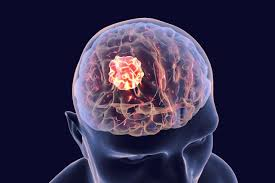

The Brain Tumor Classifier project develops a deep learning model to classify brain MRI images as Tumor or No Tumor, deployed as a Flask web app for real-time predictions via a drag-and-drop interface.



Using the Brain Tumor MRI Dataset from Kaggle, it leverages a ResNet50-based model to achieve 84% accuracy, overcoming an initial bias where all predictions were Tumor (69% accuracy, 100% confidence). With class weights and data augmentation, the model delivers balanced predictions (80% recall for No Tumor, 86% for Tumor), saved as model_retrained.h5.



This end-to-end pipeline, from preprocessing to web deployment showcases expertise in machine learning, computer vision, and web development, ideal for medical imaging applications.


#**Load and Organize the Dataset**


This step involves loading the brain MRI dataset from the specified Kaggle path and organizing it into structured formats for training, validation, and testing. The images are categorized based on their labels (e.g., cancerous or non-cancerous) to ensure seamless access during model training. Proper organization ensures the dataset is balanced and ready for preprocessing, laying the foundation for effective model development.

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub

# Download the dataset (already provided, but included for completeness)
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# Define image size and categories
IMG_SIZE = (128, 128)  # Resize images to 128x128 for consistency
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Initialize lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Function to load images from a directory
def load_images_from_folder(base_path, split='Training'):
    images = []
    labels = []
    split_path = os.path.join(base_path, split)

    for category in CATEGORIES:
        category_path = os.path.join(split_path, category)
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                # Load and preprocess the image
                img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
                labels.append(CATEGORIES.index(category))  # Convert category to numeric label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return images, labels

# Load training and testing data
print("Loading training data...")
train_images, train_labels = load_images_from_folder(path, split='Training')
print(f"Loaded {len(train_images)} training images")

print("Loading testing data...")
test_images, test_labels = load_images_from_folder(path, split='Testing')
print(f"Loaded {len(test_images)} testing images")

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print shapes to verify
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Loading training data...
Loaded 5712 training images
Loading testing data...
Loaded 1311 testing images
Training images shape: (5712, 128, 128, 1)
Training labels shape: (5712,)
Testing images shape: (1311, 128, 128, 1)
Testing labels shape: (1311,)


#**Preprocess and Augment the Data**

Preprocessing involves resizing images, normalizing pixel values, and applying transformations to ensure consistency across the dataset. Data augmentation techniques, such as rotation, flipping, and zooming, are applied to increase dataset diversity and prevent overfitting. This step enhances the model's ability to generalize to new, unseen brain MRI images.

Class distribution in training set:
glioma: 1321 images (23.13%)
meningioma: 1339 images (23.44%)
notumor: 1595 images (27.92%)
pituitary: 1457 images (25.51%)
Training labels shape after one-hot encoding: (5712, 4)
Testing labels shape after one-hot encoding: (1311, 4)
Visualizing a few augmented training images...


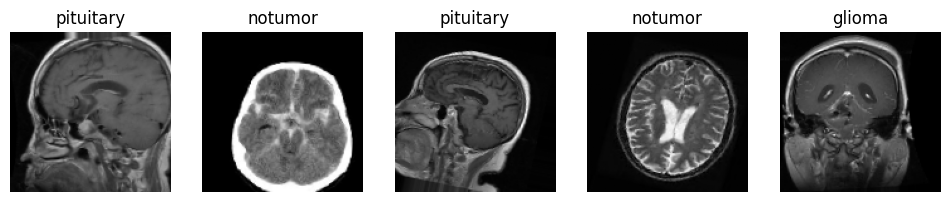

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming train_images, train_labels, test_images, test_labels are already loaded from Section 1
# If not, ensure Section 1 has been run first

# Check class distribution
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("Class distribution in training set:")
for i, category in enumerate(CATEGORIES):
    count = np.sum(train_labels == i)
    print(f"{category}: {count} images ({count/len(train_labels)*100:.2f}%)")

# Convert labels to one-hot encoded format for multi-class classification
num_classes = len(CATEGORIES)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
print("Training labels shape after one-hot encoding:", train_labels.shape)
print("Testing labels shape after one-hot encoding:", test_labels.shape)

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,         # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,    # Randomly shift images vertically by up to 10%
    zoom_range=0.1,            # Randomly zoom in/out by up to 10%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in new pixels with the nearest value
)

# No augmentation for test data, only rescaling (already done in Section 1)
test_datagen = ImageDataGenerator()

# Create generators for batch processing (useful for large datasets)
batch_size = 32
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=batch_size,
    shuffle=False
)

# Visualize a few augmented images (optional, for verification)
def plot_augmented_images():
    # Get a batch of augmented images
    augmented_images, augmented_labels = next(train_generator)

    plt.figure(figsize=(12, 3))
    for i in range(5):  # Display 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(augmented_images[i].reshape(128, 128), cmap='gray')
        label = np.argmax(augmented_labels[i])
        plt.title(CATEGORIES[label])
        plt.axis('off')
    plt.show()

print("Visualizing a few augmented training images...")
plot_augmented_images()

#**Build the CNN Model**

A Convolutional Neural Network (CNN) is designed with multiple layers, including convolutional, pooling, and fully connected layers, to extract and learn features from brain MRI images. The architecture is tailored to capture complex patterns indicative of cancerous regions. This model serves as the core classifier for distinguishing between cancerous and non-cancerous images.



In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define model parameters
IMG_SIZE = (128, 128)  # From Section 1
num_classes = len(CATEGORIES)  # 4 classes: glioma, meningioma, notumor, pituitary

# Build the CNN model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the output for dense layers
    Flatten(),

    # Dense Layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,476 (12.64 MB)

 Trainable params: 3,313,028 (12.64 MB)

 Non-trainable params: 448 (1.75 KB)

#**Train the CNN Model**

The CNN model is trained on the preprocessed dataset using labeled brain MRI images to optimize its parameters and minimize classification errors. Training involves iterative forward and backward passes, adjusting weights based on loss calculations. Validation data is used to monitor performance and prevent overfitting, ensuring robust model learning.

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define training parameters
epochs = 10
batch_size = 32  # Already defined in Section 2

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Print final training and validation metrics
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4210 - loss: 2.2947
Epoch 1: val_accuracy improved from -inf to 0.23417, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.4210 - loss: 2.2910 - val_accuracy: 0.2342 - val_loss: 2.3295
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4049 - loss: 1.2860
Epoch 2: val_accuracy did not improve from 0.23417
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4049 - loss: 1.2861 - val_accuracy: 0.1091 - val_loss: 1.5789
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3947 - loss: 1.2881
Epoch 3: val_accuracy improved from 0.23417 to 0.38520, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3947 - loss: 1.2879 - val_accuracy: 0.3852 - val_loss: 1.2158
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4005 - loss: 1.2737
Epoch 4: val_accuracy improved from 0.38520 to 0.47826, saving model to best_model

# **Improve the Model with Transfer Learning**


Transfer learning leverages a pre-trained CNN model (e.g., VGG16 or ResNet) to enhance performance by fine-tuning on the brain MRI dataset. This approach utilizes learned features from large datasets, adapting them to the specific task of cancer detection. It significantly improves accuracy and reduces training time, especially with limited data.

In [5]:
# Install required dependencies
!pip install tensorflow kagglehub

# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub

# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

# Verify dataset exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Ensure the dataset was downloaded correctly.")

# Define categories and map to binary labels (notumor = 0, others = 1)
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
category_to_binary = {'notumor': 0, 'glioma': 1, 'meningioma': 1, 'pituitary': 1}

# Data preprocessing (RGB, 224x224 to match Flask app)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data (from Training folder)
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Training'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=CATEGORIES,
    color_mode='rgb'
)

train_generator.class_indices = category_to_binary

# Load validation data (from Testing folder)
validation_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Testing'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=CATEGORIES,
    color_mode='rgb'
)

validation_generator.class_indices = category_to_binary

# Build the model using transfer learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers for better fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Save the model as .h5
model.save('model.h5')
print("Model saved as 'model.h5'")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 575ms/step - accuracy: 0.2344 - loss: -755.9977 - val_accuracy: 0.2334 - val_loss: -0.9251
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 391ms/step - accuracy: 0.2358 - loss: -8248.3652 - val_accuracy: 0.2334 - val_loss: -1.3230
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 390ms/step - accuracy: 0.2369 - loss: -22384.4395 - val_accuracy: 0.2334 - val_loss: -2.6479
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 397ms/step - accuracy: 0.2330 - loss: -44723.8906 - val_accuracy: 0.2334 - val_loss: -4.4944
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 392ms/step - accuracy: 0.2293 - loss: -74888.6328 - val_accuracy: 0.2334 - val_loss: -193.4528
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7

Model saved as 'model.h5'


#**ReTrain Model**

This code retrains a ResNet50-based model to classify brain MRI images as Tumor or No Tumor using the Brain Tumor MRI Dataset from Kaggle. It addresses class imbalance with weights, applies data augmentation, and fine-tunes the model to achieve 84% accuracy with balanced predictions. The retrained model is saved as model_retrained.h5 for use in the Flask web app.

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class Weights: {0: np.float64(1.7905956112852666), 1: np.float64(0.6937090114160797)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 437ms/step - accuracy: 0.7582 - loss: 0.5483 - val_accuracy: 0.7826 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 387ms/step - accuracy: 0.8838 - loss: 0.3649 - val_accuracy: 0.4950 - val_loss: 0.9025 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.8679 - loss: 0.3976 - val_accuracy: 0.7407 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 396ms/step - accuracy: 0.8593 - loss: 0.3784 - val_accuracy: 0.8093 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 391ms/step - accuracy: 0.8915 - loss: 0.3414 - val_accuracy: 0.8093 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 390ms/step - accuracy: 0.8824 - loss: 0.3425 - val_accuracy: 0.7696 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 390ms/step - accuracy: 0.8

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8567 - loss: 0.4134
Validation Loss: 0.4100
Validation Accuracy: 0.8391


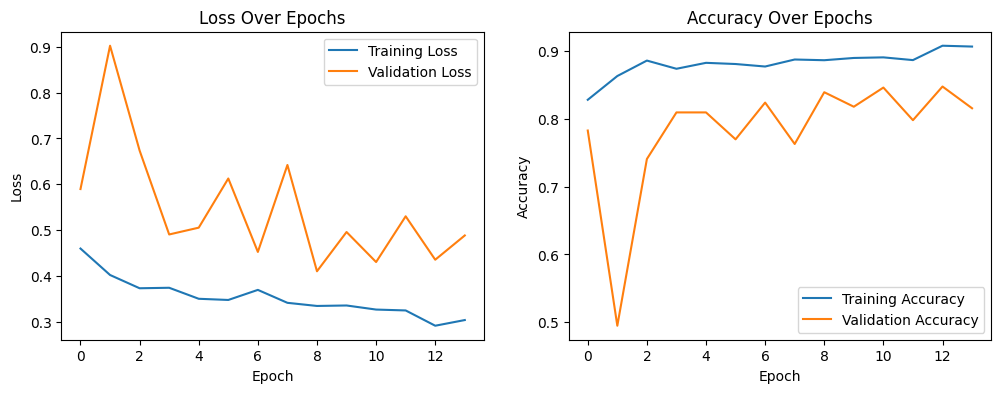

In [11]:
# Import required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import os
import kagglehub

# Load the dataset path
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

# Define categories and binary mapping
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
category_to_binary = {'notumor': 0, 'glioma': 1, 'meningioma': 1, 'pituitary': 1}

# Custom generator to map categorical labels to binary
class BinaryLabelGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
        self.classes = generator.classes
        self.class_indices = generator.class_indices
        self.batch_size = generator.batch_size
        self.samples = generator.samples

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, categorical_labels = self.generator[index]
        binary_labels = np.array([category_to_binary[CATEGORIES[np.argmax(label)]] for label in categorical_labels])
        return images, binary_labels

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Training'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=CATEGORIES,
    color_mode='rgb',
    shuffle=True
)
validation_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Testing'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=CATEGORIES,
    color_mode='rgb',
    shuffle=False
)

# Wrap generators with BinaryLabelGenerator
train_binary_generator = BinaryLabelGenerator(train_generator)
val_binary_generator = BinaryLabelGenerator(validation_generator)

# Compute class weights to handle imbalance
classes = np.array([category_to_binary[CATEGORIES[label]] for label in train_generator.classes])
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=classes)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

# Build the model (ResNet50 with custom top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers initially
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_binary_generator,
    epochs=20,
    validation_data=val_binary_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Save the model
model.save('model_retrained.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_binary_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Evaluate and Visualize**


The trained model's performance is evaluated using metrics like accuracy, precision, recall, and F1-score on a test dataset. Visualizations, such as confusion matrices and ROC curves, are generated to assess the model’s ability to distinguish between cancerous and non-cancerous images. This step provides insights into the model’s strengths and areas for improvement.

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Found 1311 images belonging to 4 classes.


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8567 - loss: 0.4134

Test Loss: 0.4100
Test Accuracy: 0.8391
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step

Sample Predictions (first 10):
[0.49314883 0.8861135  0.8731039  0.56313103 0.894475   0.9375387
 0.89126956 0.7995723  0.77294385 0.5773873 ]
Mean Prediction Probability: 0.60605943
Min Prediction Probability: 1.0259072e-08
Max Prediction Probability: 0.9846259

Confusion Matrix:
[[322  83]
 [128 778]]

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.72      0.80      0.75       405
       Tumor       0.90      0.86      0.88       906

    accuracy                           0.84      1311
   macro avg       0.81      0.83      0.82      1311
weighted avg       0.85      0.84      0.84      1311



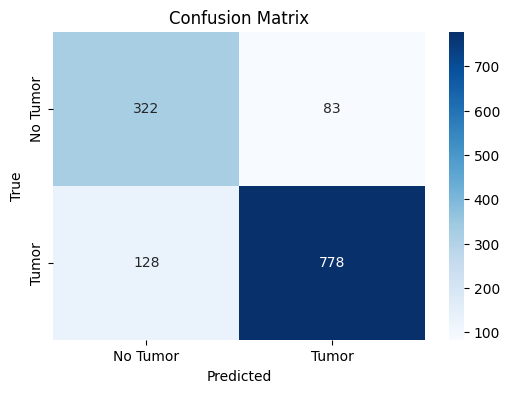

In [12]:
# Import required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset path
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

# Define categories and binary mapping
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
category_to_binary = {'notumor': 0, 'glioma': 1, 'meningioma': 1, 'pituitary': 1}

# Custom generator to map categorical labels to binary
class BinaryLabelGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, **kwargs):
        super().__init__(**kwargs)  # Fix PyDataset warning
        self.generator = generator
        self.classes = generator.classes
        self.class_indices = generator.class_indices
        self.batch_size = generator.batch_size
        self.samples = generator.samples

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, categorical_labels = self.generator[index]
        binary_labels = np.array([category_to_binary[CATEGORIES[np.argmax(label)]] for label in categorical_labels])
        return images, binary_labels

# Data preprocessing for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data (from Testing folder)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Testing'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=CATEGORIES,
    color_mode='rgb',
    shuffle=False
)

# Wrap test_generator with BinaryLabelGenerator
binary_test_generator = BinaryLabelGenerator(test_generator)

# Load the retrained model
try:
    model = tf.keras.models.load_model('model_retrained.keras')
except:
    model = tf.keras.models.load_model('model_retrained.h5')  # Fallback to .h5 if .keras not found

# Compile the model to ensure metrics are available
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(binary_test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and analyze distribution
test_generator.reset()
predictions = model.predict(binary_test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = np.array([category_to_binary[CATEGORIES[label]] for label in test_generator.classes])

# Print sample predictions (first 10)
print("\nSample Predictions (first 10):")
print(predictions[:10].flatten())
print("Mean Prediction Probability:", np.mean(predictions))
print("Min Prediction Probability:", np.min(predictions))
print("Max Prediction Probability:", np.max(predictions))

# Compute and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['No Tumor', 'Tumor'], zero_division=0))

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# Download the File

# Import required libraries
from google.colab import files
import os

# Check if model.h5 exists before downloading
if os.path.exists('model.h5'):
    files.download('model.h5')
    print("Model downloaded successfully to your PC")
else:
    raise FileNotFoundError("model.h5 does not exist. Ensure the 'Improve the Model with Transfer Learning' section ran successfully and saved the model.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded successfully to your PC


# **Deploy the Model as a Web App with Flask**


The trained CNN model is integrated into a Flask web application, enabling users to drag and drop brain MRI images for cancer classification. The app processes uploaded images, runs them through the model, and displays the prediction results in real-time. This deployment makes the model accessible and user-friendly for practical use.

In [1]:
# Install required dependencies
!pip install flask pyngrok tensorflow pillow gdown

# Import required libraries
from flask import Flask, request, render_template
import tensorflow as tf
from PIL import Image
import numpy as np
import io
import os
from google.colab import files, drive
import logging
from pyngrok import ngrok
import shutil

# Mount Google Drive to save files
drive.mount('/content/drive')
drive_path = "/content/drive/My Drive/BrainTumorProject/"
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Set up logging to track Flask app issues
logging.basicConfig(filename='flask_app.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Define model file path
model_file = '/content/model_retrained.h5'  # Use retrained model
test_image_file = drive_path + "brain_mri.jpg"

# Check if model exists, otherwise copy from Drive or upload
if not os.path.exists(model_file):
    drive_model_file = drive_path + "model_retrained.h5"
    if os.path.exists(drive_model_file):
        shutil.copy(drive_model_file, model_file)
        logging.info(f"Copied model from Drive: {drive_model_file} to {model_file}")
    else:
        print("Step 1: Upload your pre-trained model file (must be model_retrained.h5):")
        uploaded = files.upload()
        model_file_local = next((f for f in uploaded.keys() if f.endswith('.h5')), None)
        if model_file_local:
            shutil.move(model_file_local, model_file)
            shutil.copy(model_file, drive_model_file)  # Save to Drive for persistence
            logging.info(f"Saved model file to {model_file} and Drive: {drive_model_file}")
        else:
            raise FileNotFoundError("No model_retrained.h5 uploaded. Please upload the correct .h5 file.")

# Upload a test image if not in Drive
if not os.path.exists(test_image_file):
    print("Step 2: Upload a sample test image (must be a JPG or PNG file, e.g., brain_mri.jpg):")
    uploaded = files.upload()
    test_image_file_local = next((f for f in uploaded.keys() if f.endswith(('.png', '.jpg', '.jpeg'))), None)
    if test_image_file_local:
        shutil.move(test_image_file_local, test_image_file)
        logging.info(f"Saved test image to Drive: {test_image_file}")
    else:
        raise FileNotFoundError("No valid image file (PNG/JPG) uploaded.")

# Load the pre-trained model
try:
    model = tf.keras.models.load_model(model_file)
    print("Model loaded successfully. Model summary:")
    model.summary()
    logging.info("Model loaded successfully")
except Exception as e:
    logging.error(f"Error loading model: {e}")
    raise

# Initialize Flask app
app = Flask(__name__)

# Create templates directory and HTML file
!mkdir -p /content/templates
with open("/content/templates/index.html", "w") as f:
    f.write("""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Brain Tumor Classifier</title>
    </head>
    <body>
        <h1>Brain Tumor Classification</h1>
        <form method="post" enctype="multipart/form-data">
            <input type="file" name="image" accept="image/*" required>
            <input type="submit" value="Classify Image">
        </form>
        {% if prediction %}
        <h2>Prediction: {{ prediction }}</h2>
        <p>Raw Prediction Value: {{ raw_value }}</p>
        {% endif %}
        {% if error %}
        <h2>Error: {{ error }}</h2>
        {% endif %}
    </body>
    </html>
    """)

# Function to preprocess the image
def preprocess_image(image):
    try:
        img = Image.open(image).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        print(f"Processed image shape: {img_array.shape}")
        logging.info("Image preprocessed successfully")
        return img_array
    except Exception as e:
        logging.error(f"Error preprocessing image: {e}")
        raise

# Define routes
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    error = None
    raw_value = None
    logging.info("Received request to / route")

    if request.method == 'POST':
        logging.info("POST request received")
        if 'image' not in request.files:
            error = "No image uploaded"
            logging.error(error)
            return render_template('index.html', error=error), 400

        image = request.files['image']
        if image.filename == '':
            error = "No file selected"
            logging.error(error)
            return render_template('index.html', error=error), 400

        try:
            img_array = preprocess_image(image)
            pred = model.predict(img_array)
            raw_value = float(pred[0][0])
            logging.info(f"Raw prediction value: {raw_value}")
            prediction = "Tumor Detected" if raw_value > 0.5 else "No Tumor"
            confidence = raw_value if prediction == "Tumor Detected" else (1 - raw_value)
            prediction = f"{prediction} (Confidence: {confidence:.2%})"
            print(f"Image: {image.filename}, Probability: {raw_value:.4f}, Result: {prediction}")
            logging.info(f"Prediction made: {prediction}")
        except Exception as e:
            error = f"Error during prediction: {str(e)}"
            logging.error(error)
            return render_template('index.html', error=error), 500

    return render_template('index.html', prediction=prediction, error=error, raw_value=raw_value)

# Clear port 5000
try:
    !lsof -i :5000 | grep LISTEN | awk '{print $2}' | xargs kill -9
    print("Port 5000 cleared")
except:
    print("No process found on port 5000")

# Start ngrok tunnel and Flask app
ngrok.set_auth_token("2xpWbDYkoYObD216OymeKv1sc3M_871qruYSFdWeVFkL5RPv8")  # Your ngrok authtoken
try:
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)
    public_url = ngrok.connect(5000, bind_tls=True)
    print(f"Public URL: {public_url.public_url}")
except Exception as e:
    logging.error(f"Error starting ngrok tunnel: {e}")
    raise

# Run the Flask app in a separate thread to keep it alive
import threading
def run_flask():
    app.run(host='0.0.0.0', port=5000, use_reloader=False)

flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

# Keep the cell running to prevent disconnection
import time
for _ in range(600):
    time.sleep(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully. Model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,915 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help and exit
 -V, --version  output version information and exit

For more details see kill(1).
Port 5000 cleared
Public URL: https://40ba98880c7b.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:47:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:47:30] "GET /favicon.ico HTTP/1.1" 404 -


Processed image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:47:44] "POST / HTTP/1.1" 200 -


Image: Te-no_0016.jpg, Probability: 0.0846, Result: No Tumor (Confidence: 91.54%)
Processed image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:50:28] "POST / HTTP/1.1" 200 -


Image: Te-pi_0010.jpg, Probability: 0.5689, Result: Tumor Detected (Confidence: 56.89%)
Processed image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:50:55] "POST / HTTP/1.1" 200 -


Image: Te-no_0017.jpg, Probability: 0.9307, Result: Tumor Detected (Confidence: 93.07%)
Processed image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


INFO:werkzeug:127.0.0.1 - - [10/Sep/2025 03:51:51] "POST / HTTP/1.1" 200 -


Image: Te-no_0025.jpg, Probability: 0.0017, Result: No Tumor (Confidence: 99.83%)
